# Lectura del fichero csv

In [8]:
%matplotlib qt

import matplotlib
import matplotlib.pyplot as plt
import pathlib
import mne
import pandas as pd
import numpy as np

In [9]:
matplotlib.use('Qt5Agg')

In [273]:
data = pd.read_csv('data.csv')

# Quitamos las columnas de tiempo ya que mne trabaja con la sfreq
data.drop(["Time", "Timestamp"], axis=1, inplace=True)

sfreq = 250 # samples por segundo

ch_types = ["eeg"]*(data.shape[1]-1)
ch_types.append("stim")

# Usamos los nombres del csv
ch_names = []
for i in range(data.shape[1]):
  ch_names.append(data.columns[i])

montage = mne.channels.make_standard_montage("standard_1020")
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

samples = data.T*1e-6 # Esta en uV en el fichero pero mne lo interpreta como V

samples.values[8] *=1e+6 # Los eventos los devolvemos a su valor sin dividir por 1e-6

raw = mne.io.RawArray(samples, info)
raw.set_montage(montage = montage)

Creating RawArray with float64 data, n_channels=9, n_times=45265
    Range : 0 ... 45264 =      0.000 ...   181.056 secs
Ready.


<RawArray | 9 x 45265 (181.1 s), ~3.1 MB, data loaded>

In [ ]:
raw.save(pathlib.Path('out_data') / 'eeg_raw.fif', overwrite=True)

In [274]:
events = mne.find_events(raw)

111 events found
Event IDs: [1 2]


In [275]:
# Creamos un diccionario para etiquetar los eventos
events_id = {
    'Target': 1,
    'NoTarget': 2
}

In [9]:
raw.plot(events=events, event_id=events_id)

<MNEBrowseFigure size 1575x1006 with 4 Axes>

Channels marked as bad: none


# Recortado y filtrado (notch y paso banda) del EEG

In [10]:
events[0]

array([19341,     0,     2], dtype=int64)

In [16]:
# El primer evento sucede en la sample 19341
# El ultimo en la sample 32466

# Recortamos los datos 100 antes de ese punto hasta 100 samples del ultimo

start = events[0, 0] - 100
end = events[-1, 0] + 100

raw_cropped = raw.copy().crop(tmin=start/sfreq, tmax=end/sfreq)

In [33]:
raw.times[-1] # Tiempo del original

181.056

In [34]:
raw_cropped.times[-1] # Tiempo del recortado

53.3

In [24]:
raw_cropped.plot()

<MNEBrowseFigure size 1920x1017 with 4 Axes>

Channels marked as bad: none


In [35]:
# Volvemos a coger los eventos pero para la version recortada
events = mne.find_events(raw_cropped)

111 events found
Event IDs: [1 2]


In [52]:
raw_cropped_filtered = raw_cropped.copy().notch_filter(50)
raw_cropped_filtered = raw_cropped_filtered.copy().filter(l_freq=1, h_freq=50)
# En caso de que falle, es por que los datos al ser muchos no se han cargado, para ello
# hay que hacer previamente un --> raw_cropped.load_data()

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 

In [43]:
raw_cropped.plot(events=events, event_id=events_id, title="Sin paso banda")
raw_cropped_filtered.plot(events=events, event_id=events_id, title="Filtrada con paso banda")

<MNEBrowseFigure size 958x1008 with 4 Axes>

Channels marked as bad: none
Channels marked as bad: none


In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)

raw_cropped.plot_psd(ax=ax[0], show=False)
raw_cropped_filtered.plot_psd(ax=ax[1], show=False)

ax[0].set_title('PSD before filtering')
ax[1].set_title('PSD after filtering')
ax[1].set_xlabel('Frequency (Hz)')
fig.set_tight_layout(True)
plt.show()

Effective window size : 8.192 (s)
Effective window size : 8.192 (s)


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


# Guardamos los datos en formato FIF

In [58]:
raw_cropped_filtered.save(pathlib.Path('out_data') / 'eeg_cropped_filt_raw.fif', overwrite=True)

Writing E:\UNIVERSIDAD\TFG\pybrain_mne\out_data\eeg_cropped_filt_raw.fif
Closing E:\UNIVERSIDAD\TFG\pybrain_mne\out_data\eeg_cropped_filt_raw.fif
[done]


# Para mayor compatibilidad y portabilidad organizo los datos en base a la especificacion BIDS
Especificacion: https://mne.tools/mne-bids/stable/index.html

In [1]:
import mne_bids

In [252]:
raw = mne.io.read_raw('out_data/eeg_raw.fif')

events = mne.find_events(raw)
events_id = {
    'Target': 1,
    'NoTarget': 2
}

Opening raw data file out_data/eeg_raw.fif...
    Range : 0 ... 45264 =      0.000 ...   181.056 secs
Ready.
111 events found
Event IDs: [1 2]


In [253]:
# Especificamos la frecuencia de la red electrica a la que se realiza el experimento
raw.info['line_freq'] = 50

In [254]:
# Si queremos especificar informacion del sujeto
subject_info = {
    'sex': 1,
    'hand': 2,
    'birthday': (1999, 8, 23)
}

raw.info['subject_info'] = subject_info

In [213]:
# TODO: establecer la fecha del experimento, ¿como? ¿raw.info['meas_date']?
raw.info['meas_date'] = datetime.datetime(2002, 12, 3, 19, 1, 10, 720100, tzinfo=datetime.timezone.utc)

In [255]:
out_path = pathlib.Path('out_data/sample_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='visual',
                              run='01',
                              root=out_path)

# Añadimos los eventos tambien a los datos en formato BIDS
mne_bids.write_raw_bids(raw, bids_path=bids_path, events_data=events, event_id=events_id, overwrite=True, verbose=False)
# Parametro verbose=False para que no salga tanto texto

Opening raw data file out_data/eeg_raw.fif...
    Range : 0 ... 45264 =      0.000 ...   181.056 secs
Ready.
Reading 0 ... 45264  =      0.000 ...   181.056 secs...


BIDSPath(
root: out_data\sample_BIDS
datatype: eeg
basename: sub-01_ses-01_task-visual_run-01_eeg.vhdr)

In [256]:
mne_bids.print_dir_tree(out_path)

|sample_BIDS\
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- .ipynb_checkpoints\
|------ README-checkpoint
|------ dataset_description-checkpoint.json
|--- sub-01\
|------ ses-01\
|--------- sub-01_ses-01_scans.tsv
|--------- .ipynb_checkpoints\
|------------ sub-01_ses-01_scans-checkpoint.tsv
|--------- eeg\
|------------ sub-01_ses-01_coordsystem.json
|------------ sub-01_ses-01_electrodes.tsv
|------------ sub-01_ses-01_task-visual_run-01_channels.tsv
|------------ sub-01_ses-01_task-visual_run-01_eeg.eeg
|------------ sub-01_ses-01_task-visual_run-01_eeg.json
|------------ sub-01_ses-01_task-visual_run-01_eeg.vhdr
|------------ sub-01_ses-01_task-visual_run-01_eeg.vmrk
|------------ sub-01_ses-01_task-visual_run-01_events.tsv


In [10]:
bids_root = pathlib.Path('out_data/sample_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='visual',
                              run='01',
                              datatype='eeg',
                              root=bids_root)

raw = mne_bids.read_raw_bids(bids_path, verbose=False)

Extracting parameters from out_data\sample_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-visual_run-01_eeg.vhdr...
Setting channel info structure...
Reading events from out_data\sample_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-visual_run-01_events.tsv.
Reading channel info from out_data\sample_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-visual_run-01_channels.tsv.
Reading electrode coords from out_data\sample_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_electrodes.tsv.


<ipython-input-10-55cddb179ab5>:10: RuntimeWarning: The unit for channel(s) Estimulo has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)
<ipython-input-10-55cddb179ab5>:10: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Estimulo']
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


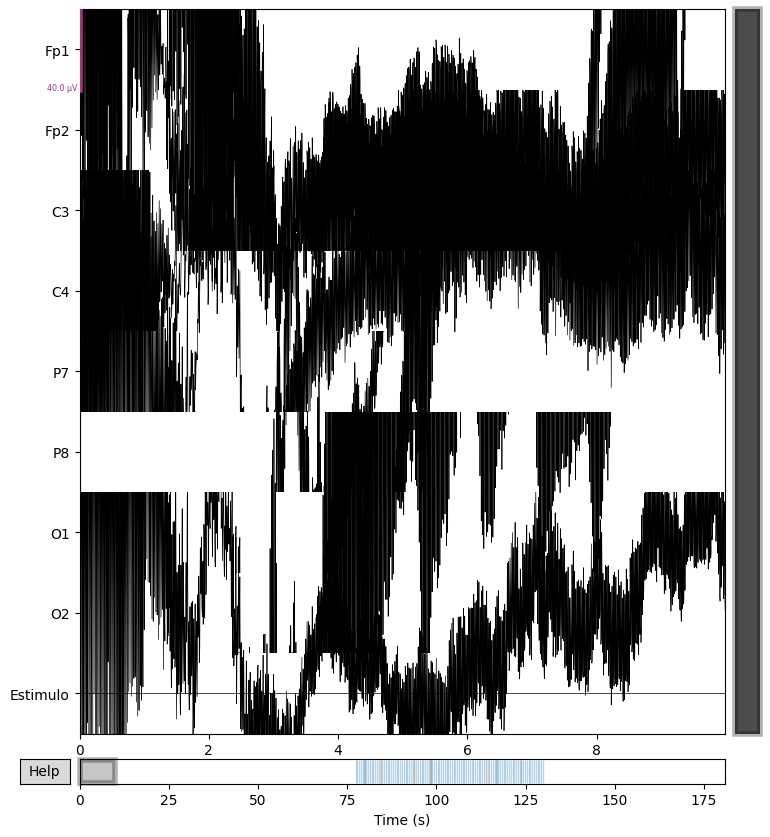

Channels marked as bad: none


In [11]:
raw.plot()

In [260]:
raw.annotations

<Annotations | 111 segments: NoTarget (106), Target (5)>

In [263]:
# Por algun motivo las id's pasan de valor n a valor 10000+n
events, events_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['NoTarget', 'Target']


In [234]:
mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info['sfreq'])

<Figure size 1092x480 with 1 Axes>

# Creacion de 'Epochs'

In [279]:
# Cargamos los datos en formato BIDS
bids_root = pathlib.Path('out_data/sample_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='visual',
                              run='01',
                              datatype='eeg',
                              root=bids_root)

raw = mne_bids.read_raw_bids(bids_path, verbose=False)

raw.load_data() # Importante cargarla, ya no hay precarga de datos

raw.filter(l_freq=1, h_freq=17)
events, events_id = mne.events_from_annotations(raw)

Extracting parameters from out_data\sample_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-visual_run-01_eeg.vhdr...
Setting channel info structure...
Reading events from out_data\sample_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-visual_run-01_events.tsv.
Reading channel info from out_data\sample_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-visual_run-01_channels.tsv.
Reading electrode coords from out_data\sample_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_electrodes.tsv.
Reading 0 ... 45264  =      0.000 ...   181.056 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 17 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 17.00 Hz
- Upper transition bandwidth: 4.25 Hz

<ipython-input-279-d59623a98906>:11: RuntimeWarning: The unit for channel(s) Estimulo has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)
<ipython-input-279-d59623a98906>:11: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Estimulo']
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


In [280]:
events_id

{'NoTarget': 10001, 'Target': 10002}

In [352]:
# Tiempo en segundos
tmin = -0.3
tmax = 0.6

# The time interval to consider as “baseline” when applying baseline correction
# Desde el inicio de la Epoc (None), hasta el momento en el que justo se da t= 0
baseline = (None, 0)
# baseline = (-0.2, 0) para coger 200ms desde antes del estimulo hasta el t=0

# Correction is applied to each epoch and channel individually in the following way:
    # 1.- Calculate the mean signal of the baseline period.
    # 2.- Subtract this mean from the entire epoch.

epochs = mne.Epochs(raw,
                    events=events,
                    event_id=events_id,
                    tmin=tmin,
                    tmax=tmax,
                    baseline=baseline,
                    preload=True)
epochs

Not setting metadata
Not setting metadata
111 matching events found
Setting baseline interval to [-0.3, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 111 events and 226 original time points ...
0 bad epochs dropped


<Epochs |  111 events (all good), -0.3 - 0.6 sec, baseline [-0.3, 0] sec, ~1.7 MB, data loaded,
 'NoTarget': 106
 'Target': 5>

In [289]:
epochs.plot(events=events, event_id=events_id)

<MNEBrowseFigure size 1920x1017 with 4 Axes>

Dropped 0 epochs: 
Channels marked as bad: none


In [353]:
epochs

<Epochs |  111 events (all good), -0.3 - 0.6 sec, baseline [-0.3, 0] sec, ~1.7 MB, data loaded,
 'NoTarget': 106
 'Target': 5>

In [284]:
# Tras descartar una Epoch, vemos que se ha eliminado de nuestro conjunto de epocas

In [311]:
# Nos podemos quedar con las epocas de un solo tipo de estimulo
epochs['Target'].plot(events=events, event_id=events_id)

<MNEBrowseFigure size 1920x1017 with 4 Axes>

Dropped 0 epochs: 
Channels marked as bad: none


In [318]:
epochs['Target'].plot_image()
# Se muestra un grafico del voltaje y una grafica del valor medio en cada punto
# Basicamente lo mismo pero abajo todas las Epochs juntas

Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


[<Figure size 640x480 with 3 Axes>]

# Guardamos las 'Epochs'

In [354]:
epochs.save(pathlib.Path('out_data') / 'epochs_epo.fif', overwrite=True)

Overwriting existing file.


# Tratamiento de ERP

In [355]:
evoked = epochs['Target'].average()

In [356]:
evoked

<Evoked | 'Target' (average, N=5), [-0.3, 0.6] sec, 8 ch, ~31 kB>

In [357]:
evoked.plot(spatial_colors=True)

<Figure size 640x300 with 2 Axes>

In [358]:
times=np.arange(-0.05, 0.61, 0.05)
evoked.plot_topomap(ch_type='eeg', times=times, nrows=3)
# Se puede observar el caracteristico descenso del voltaje del P300

<MNEFigure size 900x610 with 15 Axes>

In [359]:
# Combinacion de las anteriores
# Interesante porque añade marcas de tiempo a los topomapas autogenerados
evoked.plot_joint(picks='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 800x420 with 7 Axes>

In [364]:
# Comparacion entre los ERP de Target y NoTarget
# Se ve perfectamente los P300 respecto a los NoTargets
evoked_nt = epochs['NoTarget'].average()
mne.viz.plot_compare_evokeds([evoked, evoked_nt], picks='eeg')

# https://www.microsiervos.com/images/OndaP300.jpg

combining channels using "gfp"
combining channels using "gfp"


[<Figure size 800x600 with 1 Axes>]

# Almacenamiento y Carga de ERPs
No muy util ya que no cuesta nada generarlo

In [365]:
mne.write_evokeds(fname=pathlib.Path('out_data') / 'evokeds_ave.fif',
                  evoked=[evoked, evoked_nt])

In [366]:
evokeds = mne.read_evokeds(fname=pathlib.Path('out_data') / 'evokeds_ave.fif')
evokeds

Reading out_data\evokeds_ave.fif ...
    Found the data of interest:
        t =    -300.00 ...     600.00 ms (Target)
        0 CTF compensation matrices available
        nave = 5 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
    Found the data of interest:
        t =    -300.00 ...     600.00 ms (NoTarget)
        0 CTF compensation matrices available
        nave = 106 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied


[<Evoked | 'Target' (average, N=5), [-0.3, 0.6] sec, 8 ch, ~32 kB>,
 <Evoked | 'NoTarget' (average, N=106), [-0.3, 0.6] sec, 8 ch, ~32 kB>]

In [367]:
evokeds[0]

<Evoked | 'Target' (average, N=5), [-0.3, 0.6] sec, 8 ch, ~32 kB>

# Eliminacion de artefactos

In [9]:
import pathlib
import matplotlib

import mne
import mne_bids

matplotlib.use('Qt5Agg')
mne.set_log_level('warning')

In [10]:
epochs = mne.read_epochs(pathlib.Path('out_data') / 'epochs_epo.fif')
epochs

<EpochsFIF |  111 events (all good), -0.3 - 0.6 sec, baseline [-0.3, 0] sec, ~1.7 MB, data loaded,
 'NoTarget': 106
 'Target': 5>

In [11]:
epochs.plot()

<MNEBrowseFigure size 958x1008 with 4 Axes>

In [15]:
# Reject epochs based on peak-to-peak signal amplitude (PTP)
# In each individual epoch, the PTP is calculated for every channel.
    # If the PTP of any one channel exceeds the threshold, the epoch will be dropped.
reject_criteria = dict(mag=3000e-15,     # 3000 fT
                       grad=3000e-13,    # 3000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=200e-6)       # 200 µV

# Rejection parameters based on flatness of signal
# The values are floats that set the minimum acceptable peak-to-peak amplitude (PTP)
flat_criteria = dict(mag=1e-15,          # 1 fT
                     grad=1e-13,         # 1 fT/cm
                     eeg=1e-6)           # 1 µV

# Ya que solo usamos eeg, las demas entradas deben quitarse, el anterior es un ejemplo
reject_criteria = dict(eeg=150e-6)       # 150 µV

flat_criteria = dict(eeg=1e-6)           # 1 µV

In [16]:
epochs.drop_bad(reject=reject_criteria, flat=flat_criteria)

<EpochsFIF |  98 events (all good), -0.3 - 0.6 sec, baseline [-0.3, 0] sec, ~1.5 MB, data loaded,
 'NoTarget': 93
 'Target': 5>

In [19]:
epochs.plot_drop_log()
# Unknown se refiere al nombre del sujeto

<Figure size 640x480 with 1 Axes>

In [22]:
epochs['Target'].plot_image()

[<Figure size 640x480 with 3 Axes>]

In [30]:
epochs.plot_sensors(ch_type='eeg')

<Figure size 640x640 with 1 Axes>

In [ ]:
# Miramos una imagen mas detallada del canal O1

In [32]:
epochs['Target'].plot_image(picks='O1')

[<Figure size 640x480 with 4 Axes>]

# SSP (Signal-Space projection) para quitar artefactos del parpadeo pero no eliminar Epochs
mayor uso en EMG, **no muy util para el TFG**

**se puede usar si se tiene un canal de EOG para eliminar los artefactos del parpadeo**

In [ ]:
bids_root = pathlib.Path('out_data/sample_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='visual',
                              run='01',
                              datatype='eeg',
                              root=bids_root)

raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()
raw.filter(l_freq=0.1, h_freq=40)

# Tambien se puede aplicar al ECG, no nos interesa tanto
#ecg_projs, ecg_events = mne.preprocessing.compute_proj_ecg(raw, n_grad=1, n_mag=1, n_eeg=0, average=True)

# Ya que no tenemos canal propio de EOG, debemos seleccionar uno del EEG
eog_projs, eog_events = mne.preprocessing.compute_proj_eog(raw, n_grad=1, n_mag=1, n_eeg=1, ch_name='O2', average=True)

In [121]:
eog_projs

In [ ]:
epochs.add_proj(eog_projs)

In [124]:
epochs.plot()
# Con el boton de abajo a la izq podemos activarlas o desactivarlas

<MNEBrowseFigure size 958x1008 with 4 Axes>

In [ ]:
epochs_cleaned = epochs.copy().apply_proj()

epochs_cleaned.plot_image()

## ICA (mayor uso en EEG), preparación previa

First, start with the **raw data** again and apply a 1.0 Hz high-pass filter, which is advantegeous for ICA performance.

In [215]:
bids_root = pathlib.Path('out_data/sample_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='visual',
                              run='01',
                              datatype='eeg',
                              root=bids_root)

raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()
raw.filter(l_freq=1, h_freq=17)  # High-pass with 1. Hz cut-off is recommended for ICA

Reading in coordinate system frame CapTrak: None.
The read in electrodes file is: 
 [('name', ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'Estimulo']), ('x', ['-0.028230102732777596', '0.028615690767765045', '-0.06266713887453079', '0.06430720537900925', '-0.06942592561244965', '0.07002179324626923', '-0.028190279379487038', '0.0286047775298357', 'n/a']), ('y', ['0.1022629365324974', '0.10319957137107849', '0.016059016808867455', '0.01671912893652916', '-0.047829363495111465', '-0.04744717478752136', '-0.08428219705820084', '-0.08399737626314163', 'n/a']), ('z', ['0.03173459693789482', '0.03159264102578163', '0.10678041726350784', '0.1060163676738739', '0.047329582273960114', '0.047286536544561386', '0.060965631157159805', '0.06092165783047676', 'n/a'])]


<ipython-input-215-45ed71fddc89>:10: RuntimeWarning: The unit for channel(s) Estimulo has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-215-45ed71fddc89>:10: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Estimulo']
  raw = mne_bids.read_raw_bids(bids_path)


<RawBrainVision | sub-01_ses-01_task-visual_run-01_eeg.eeg, 9 x 45265 (181.1 s), ~3.1 MB, data loaded>

Hay que generar un nuevo conjunto de epochs 'epochs_ica' que seran las mismas que ya tenemos almacenadas.

Pero lo que no podemos hacer es volver a aplicar otro filtro, ya que para ICA nos conviene 1HZ l_freq sobre las Epochs que ya tenemos, por lo que generamos a partir del raw data y los indices de las epochs buenas guardadas un nuevo conjunto 'epochs_ica'

**Esto no es necesario si las epochs ya estan generadas con los filtros que se estan usando para el raw ahora**

In [216]:
epochs = mne.read_epochs(pathlib.Path('out_data') / 'epochs_epo.fif')
epochs_selection = epochs.selection
epochs_selection.shape

(111,)

In [217]:
epochs
# Ya esta (None, 0) en la baseline correction

<EpochsFIF |  111 events (all good), -0.3 - 0.6 sec, baseline [-0.3, 0] sec, ~1.7 MB, data loaded,
 'NoTarget': 106
 'Target': 5>

In [218]:
# Seleccionamos los eventos correspondientes a las epocas que NO hemos descartado
events, events_id = mne.events_from_annotations(raw)
events = events[epochs_selection]

Create epochs for ICA. All parameters should match **exactly** the ones of the epochs we intend to clean.

In [219]:
# Usamos los valores de las Epochs que teniamos
tmin = epochs.tmin
tmax = epochs.tmax
baseline = epochs.baseline

epochs_ica = mne.Epochs(raw,
                        events=events,
                        event_id=events_id,
                        tmin=tmin,
                        tmax=tmax,
                        baseline=baseline,
                        preload=True)

In [220]:
epochs_ica.info

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, C3, C4, P7, P8, O1, O2, Estimulo
 chs: 8 EEG, 1 STIM
 custom_ref_applied: False
 dig: 8 items (8 EEG)
 highpass: 1.0 Hz
 line_freq: 50
 lowpass: 17.0 Hz
 meas_date: unspecified
 nchan: 9
 projs: []
 sfreq: 250.0 Hz
 subject_info: 4 items (dict)
>

# Uso de ICA

In [221]:
n_components = 0.999  # Should normally be higher, like 0.999!!
method = 'picard'
max_iter = 500  # Should normally be higher, like 500 or even 1000!!
fit_params = dict(fastica_it=5)
random_state = 42

ica = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
                            fit_params=fit_params,
                            random_state=random_state)
ica.fit(epochs_ica)

<ICA | epochs decomposition, fit (picard): 25086 samples, 8 components, channels used: "eeg">

In [222]:
ica.plot_components(inst=epochs)

[<MNEFigure size 975x496 with 8 Axes>]

# Usar artefactos para excluir componentes del ICA, en este caso del EOG

In [304]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, reject=None, ch_name='O1',
                                                 baseline=(None, -0.2),
                                                 tmin=-0.5, tmax=0.5)

In [305]:
eog_epochs

<Epochs |  3 events (all good), -0.5 - 0.5 sec, baseline [-0.5, -0.2] sec, ~71 kB, data loaded,
 '998': 3>

In [306]:
eog_evoked = eog_epochs.average()

In [315]:
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='O1')

In [316]:
eog_inds
eog_scores

array([ 0.46783591, -0.79542855,  0.14985238, -0.69866229,  0.49552845,
       -0.53679008, -0.21090312,  0.49359835])

In [309]:
components_to_exclude = eog_inds
ica.exclude = components_to_exclude

In [317]:
ica.plot_scores(eog_scores)

<Figure size 640x270 with 1 Axes>

In [318]:
ica.plot_sources(eog_evoked)

<Figure size 640x480 with 1 Axes>

In [319]:
ica.plot_overlay(eog_evoked)
# Rojo-antes negro-despues

<Figure size 640x480 with 1 Axes>

Una vez que tenemos las zonas a excluir, lo hacemos sobre nuestro conjuntos de Epochs **original** y no sobre el creado para realizar ICA

In [322]:
epochs_cleaned = ica.apply(epochs.copy())

In [325]:
epochs_cleaned.plot()

<MNEBrowseFigure size 958x1008 with 4 Axes>

In [324]:
epochs.plot(title='before')

<MNEBrowseFigure size 958x1008 with 4 Axes>

# Analisis de las Epochs (Aritmetica, ML)

In [1]:
%matplotlib qt
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne

matplotlib.use('Qt5Agg')
mne.set_log_level('warning')

In [63]:
epochs = mne.read_epochs(pathlib.Path('out_data') / 'epochs_epo.fif')
epochs.apply_baseline((None, 0))
epochs

<EpochsFIF |  111 events (all good), -0.3 - 0.6 sec, baseline [-0.3, 0] sec, ~1.7 MB, data loaded,
 'NoTarget': 106
 'Target': 5>

In [64]:
# Nos quedamos con las epocas de interes a comparar, en nuestro caso son todas
# ya que solo tenemos los eventos Target y NoTarget
epochs_auditory = epochs
epochs_auditory

<EpochsFIF |  111 events (all good), -0.3 - 0.6 sec, baseline [-0.3, 0] sec, ~1.7 MB, data loaded,
 'NoTarget': 106
 'Target': 5>

In [18]:
# De forma aritmetica podemos comparar las diferencias de uV de los ERP
evoked_diff = mne.combine_evoked(
    [epochs_auditory['NoTarget'].average(),
     epochs_auditory['Target'].average()],
    weights=[1, -1]  # Subtraction
)

evoked_diff.plot(gfp=True)

mne.viz.plot_compare_evokeds(
    [epochs_auditory['NoTarget'].average(),
     epochs_auditory['Target'].average(),
     evoked_diff],
    
)

[<Figure size 800x600 with 1 Axes>]

# Ahora con ML

In [22]:
# To keep chance level at 50% accuracy
    # we first equalize the number of epochs in each condition.
epochs_auditory.equalize_event_counts(epochs_auditory.event_id)
epochs_auditory
# OJO, en este ejemplo no lo hago ya que solo tenemos 5 eventos Target

<EpochsFIF |  10 events (all good), -0.3 - 0.6 sec, baseline [-0.3, 0] sec, ~178 kB, data loaded,
 'NoTarget': 5
 'Target': 5>

# Preparamos y escalamos los datos a mano

Mas adelante se usara una libreria de mne para facilitar esta tarea

In [66]:
import numpy as np

# Create an vector with length = no. of trials.
y = np.empty(len(epochs_auditory.events), dtype=int)  

# Which trials are LEFT, which are RIGHT?
idx_left = epochs_auditory.events[:, 2] == epochs_auditory.event_id['NoTarget']
idx_right = epochs_auditory.events[:, 2] == epochs_auditory.event_id['Target']

idx_left

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [67]:
# Encode: NoTarget = 0, Target = 1.
y[idx_left] = 0
y[idx_right] = 1

print(y)
print(f'\nSize of y: {y.size}')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

Size of y: 111


In [68]:
# for EEG channels:
epochs_auditory_grad = epochs_auditory.copy().pick_types(meg=False, eeg=True)

# Retrieve the data as a NumPy array.
# The array has the shape: (n_trials, n_channels, n_timepoints)
data = epochs_auditory_grad.get_data()
print(data.shape)

(111, 8, 226)


In [69]:
# reshape X to the dimension (n_trials, n_channels * n_timepoints)
n_trials = data.shape[0]

X = data.reshape(n_trials, -1)
print(X.shape)

(111, 1808)


# Creamos el clasificador con sklearn

In [76]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# The classifier pipeline: it is extremely important to SCALE THE DATA
# before running the actual classifier (logistic regression in our case).
clf = make_pipeline(StandardScaler(), LogisticRegression())

# Run cross-validation.
# CV without shuffling – "block cross-validation" – is what we want here
# (scikit-learn doesn't shuffle by default, which is good for us).
n_splits = 5
scoring = 'roc_auc' # area under the curve
cv = StratifiedKFold(n_splits=n_splits)
scores = cross_val_score(clf, X=X, y=y, cv=cv, scoring=scoring)

# Mean and standard deviation of ROC AUC across cross-validation runs.
roc_auc_mean = round(np.mean(scores), 3)
roc_auc_std = round(np.std(scores), 3)

print(f'CV scores: {scores}')
print(f'Mean ROC AUC = {roc_auc_mean:.3f} (SD = {roc_auc_std:.3f})')

CV scores: [1.         0.9047619  1.         0.71428571 0.23809524]
Mean ROC AUC = 0.771 (SD = 0.286)


In [77]:
fig, ax = plt.subplots()
ax.boxplot(scores,
           showmeans=True, # Green triangle marks the mean.
           whis=(0, 100),  # Whiskers span the entire range of the data.
           labels=['NoTarget vs Target'])
ax.set_ylabel('Score')
ax.set_title('Cross-Validation Scores')

Text(0.5, 1.0, 'Cross-Validation Scores')

# Ahora con `mne.decoding`

De esta forma la preparacion de los datos es mucho mas sencilla

In [98]:
from sklearn.pipeline import make_pipeline
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore

# First, create X and y.
epochs_auditory_grad = epochs_auditory.copy().pick_types(meg=False, eeg=True)
X = epochs_auditory_grad.get_data()
y = epochs_auditory_grad.events[:, 2]

# Classifier pipeline.
clf = make_pipeline(
    # An MNE scaler that correctly handles different channel types –
    # isn't that great?!
    Scaler(epochs_auditory_grad.info),
    # Remember this annoying and error-prone NumPy array reshaping we had to do
    # earlier? Not anymore, thanks to the MNE vectorizer!
    Vectorizer(),
    # And, finally, the actual classifier.
    LogisticRegression(max_iter=500))

# Run cross-validation.
# Note that we're using MNE's cross_val_multiscore() here, not scikit-learn's
# cross_val_score() as above. We simply pass the number of desired CV splits,
# and MNE will automatically do the rest for us.
cv = 5
scoring = 'roc_auc'
scores = cross_val_multiscore(clf, X, y, cv=cv, scoring='roc_auc')

# Mean and standard deviation of ROC AUC across cross-validation runs.
roc_auc_mean = round(np.mean(scores), 3)
roc_auc_std = round(np.std(scores), 3)

print(f'CV scores: {scores}')
print(f'Mean ROC AUC = {roc_auc_mean:.3f} (SD = {roc_auc_std:.3f})')

CV scores: [1.         0.76190476 1.         0.61904762 0.19047619]
Mean ROC AUC = 0.714 (SD = 0.300)


# En lugar de las Epochs tambien podemos hacer estudios punto por punto

In the previous examples, we have trained a classifier to discriminate between experimental conditions by using the spatio-temporal patterns of **entire trials**. Consequently, the classifier was (hopefully!) able to predict which activation patterns belonged to which condition. 

However, an interesting neuroscientific is: **Exactly *when* do the brain signals for two conditions differ?**

We can try to answer this question by fitting a classifier **at every single time point.** If the classifier can successfully discriminate between the two conditions, we can conclude that the spatial activation patterns measured by the MEG or EEG sensors differed **at this very time point**.

In [102]:
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator

# First, create X and y.
epochs_auditory_grad = epochs_auditory.copy().pick_types(meg=False, eeg=True)
X = epochs_auditory_grad.get_data()
y = epochs_auditory_grad.events[:, 2]

# Classifier pipeline. No need for vectorization as in the previous example.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression())

# The "sliding estimator" will train the classifier at each time point.
scoring = 'roc_auc'
time_decoder = SlidingEstimator(clf, scoring=scoring, n_jobs=1, verbose=True)

# Run cross-validation.
n_splits = 5
scores = cross_val_multiscore(time_decoder, X, y, cv=n_splits, n_jobs=1)

# Mean scores across cross-validation splits, for each time point.
mean_scores = np.mean(scores, axis=0)

# Mean score across all time points.
mean_across_all_times = round(np.mean(scores), 3)
print(f'\n=> Mean CV score across all time points: {mean_across_all_times:.3f}')



=> Mean CV score across all time points: 0.642


In [106]:
fig, ax = plt.subplots()

ax.axhline(0.5, color='k', linestyle='--', label='chance')  # AUC = 0.5
ax.axvline(0, color='k', linestyle='-')  # Mark time point zero.
ax.plot(epochs.times, mean_scores, label='score')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean ROC AUC')
ax.legend()
ax.set_title('Left vs Right')
fig.suptitle('Sensor Space Decoding')

# Aunque la media a lo largo de todo el tiempo es de 0.624, observando la grafica se ve
# como en las regiones cercanas al instante 0 y los momentos posteriores la precision
# aumenta considerablemente

Text(0.5, 0.98, 'Sensor Space Decoding')

# Analisis de la frecuencia y f-t al mismo tiempo

In [107]:
import pathlib
import matplotlib

import mne
import mne_bids

matplotlib.use('Qt5Agg')
mne.set_log_level('warning')

In [110]:
epochs = mne.read_epochs(pathlib.Path('out_data') / 'epochs_epo.fif')
epochs.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, C3, C4, P7, P8, O1, O2, Estimulo
 chs: 8 EEG, 1 STIM
 custom_ref_applied: False
 dig: 8 items (8 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 line_freq: 50.0
 lowpass: 17.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 9
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

In [109]:
epochs.apply_proj()
epochs_auditory = epochs

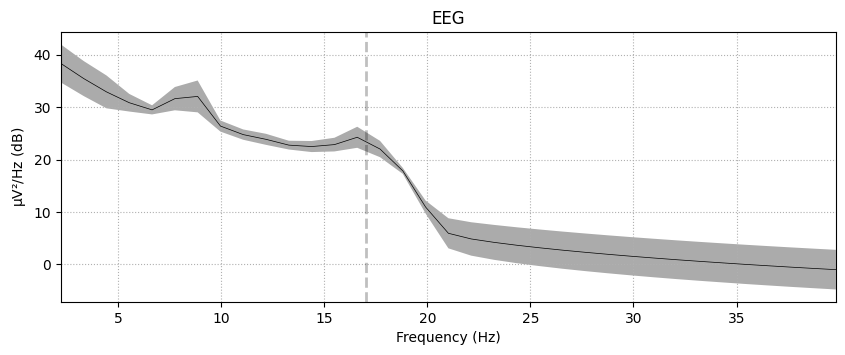

In [111]:
epochs_auditory.plot_psd(fmin=2., fmax=40., average=True, bandwidth=2)

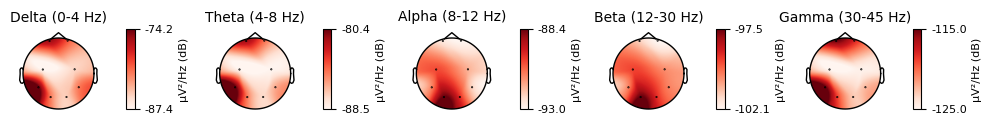

In [115]:
epochs_auditory.plot_psd_topomap(ch_type='eeg', normalize=False)

## Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs.
We'll look at power and inter-trial coherence (ITC).

To this we'll use the function `mne.time_frequency.tfr_morlet`
but you can also use `mne.time_frequency.tfr_multitaper`
or `mne.time_frequency.tfr_stockwell`.

In [118]:
import numpy as np

# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([2, 30]), num=20)
freqs

array([ 2.        ,  2.30637295,  2.65967809,  3.0671048 ,  3.53694377,
        4.07875572,  4.70356592,  5.4240886 ,  6.25498562,  7.21316481,
        8.3181241 ,  9.5923482 , 11.0617662 , 12.75627917, 14.7103686 ,
       16.9637981 , 19.56242252, 22.55912106, 26.01487328, 30.        ])

In [120]:
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(epochs_auditory, freqs=freqs, 
                                           n_cycles=n_cycles, use_fft=True,
                                           return_itc=True, decim=2, n_jobs=2)

In [122]:
power.crop(-0.1, 0.55)  # crop to remove edge artifacts

<AverageTFR | time : [-0.100000, 0.556000], freq : [2.000000, 30.000000], nave : 111, channels : 8, ~122 kB>

In [123]:
itc.crop(-0.1, 0.55)  # crop to remove edge artifacts

<AverageTFR | time : [-0.100000, 0.556000], freq : [2.000000, 30.000000], nave : 111, channels : 8, ~122 kB>

In [124]:
baseline_mode = 'logratio'
baseline = (None, 0)

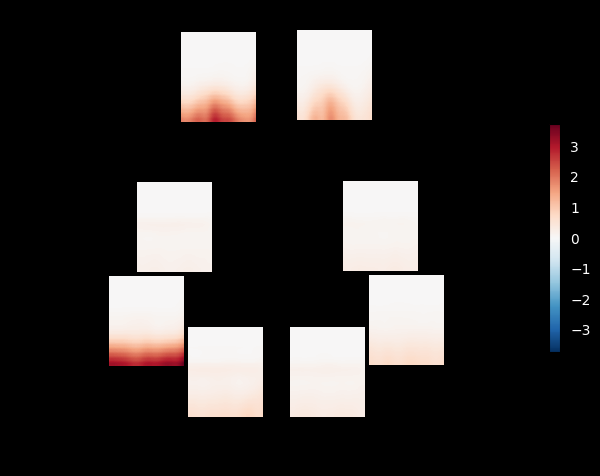

c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:270: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:270: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)


In [133]:
(power.copy()
 .pick_types(eeg=True, meg=False)
 .plot_topo())

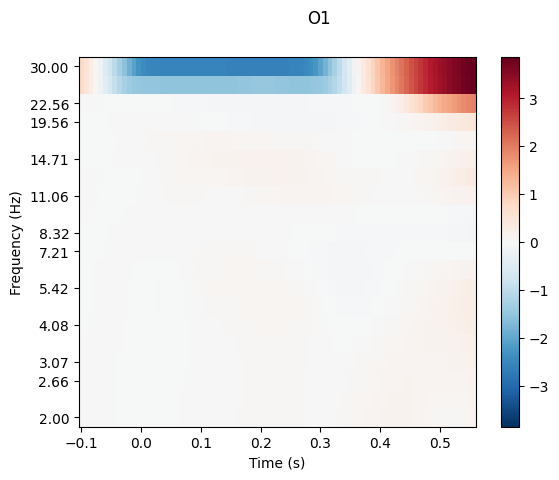

In [148]:
power.plot(picks='O1', baseline=baseline, mode=baseline_mode)

In [128]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(1, 3, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=4, fmax=7,
                   baseline=baseline, mode=baseline_mode, axes=axis[0],
                   title='Theta', show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=baseline, mode=baseline_mode, axes=axis[1],
                   title='Alpha', show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=15, fmax=30,
                   baseline=baseline, mode=baseline_mode, axes=axis[2],
                   title='Beta', show=False, contours=1)
mne.viz.tight_layout()
plt.show()

In [151]:
power.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0., 2.), (0.2, 4.)])
plt.show()

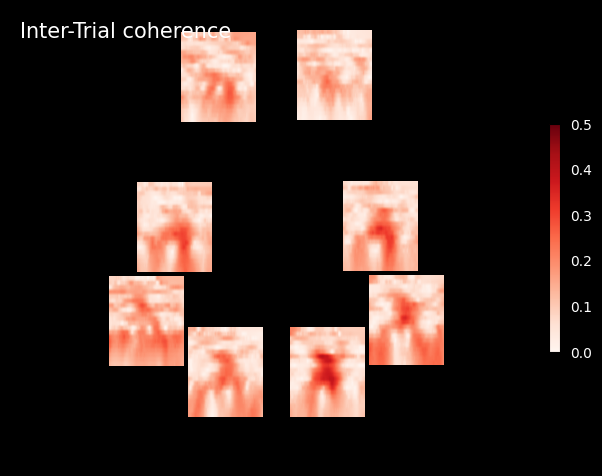

c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:270: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:270: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:270: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:270: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:270: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
c:\users\usuario\appdata\local\prog

In [152]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=0.5, cmap='Reds')